# Examen Parcial 3 - Estadistica Aplicada
Nombre: Salvador Almaguer Orta

Matrícula: 2076430

Grupo: 44

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

Has sido contratado como asesor del director de Metrorrey, la empresa encargada de administrar el metro en el área metropolitana de Monterrey, NL.El director te ha proporcionado la siguiente base de datos con la información mensual del número de pasajeros y el ingreso generado por pasajes

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/datos_metrorrey.csv', index_col='mes',  parse_dates=True)
data = data.asfreq('MS')

C:\Users\A\AppData\Local\Temp\ipykernel_6180\1419331735.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/datos_metrorrey.csv', index_col='mes',  parse_dates=True)


1.Muestre de que tipo son las variables del dataframe, revise que no haya missing values (de haberlos imputar valores). Cersiorarse que exista una variable fecha, que sea el index y tenga una frecuencia asignada(1.8 puntos)

In [11]:
print(data.dtypes)
print('\n\n',data.isnull().sum())
print('\n\nNo se presentan missing values')

miles de pasajeros           float64
ingresos (miles de pesos)    float64
dtype: object


 miles de pasajeros           0
ingresos (miles de pesos)    0
dtype: int64


No se presentan missing values


2.Análisis  exploratorio.  Utilizando  código  de  Python  genera  un  print()para  cada una de la siguiente información(8 puntos)

a)Rango de fechas

In [25]:
inicio = data.index[0]
fin = data.index[-1]

print(f'El rango de fecha de la base de datos es de: {inicio.date()} hasta {fin.date()}')

El rango de fecha de la base de datos es de: 1995-01-01 hasta 2023-08-01


b)Número de observaciones1

In [37]:
print(f'El numero de registros de la base de datos es: {data.shape[0]}')

El numero de registros de la base de datos es: 344


c)Valor mínimo y valor máximo del número de pasajeros

In [47]:
maximo = data['miles de pasajeros'].max()
minimo = data['miles de pasajeros'].min()

print(f'El minimo de pasajeros registrados en un mes es {minimo} miles de pasajeros.\nY el maximo es de {maximo} miles de pasajeros.')

El minimo de pasajeros registrados en un mes es 2397.0 miles de pasajeros.
Y el maximo es de 17534.523 miles de pasajeros.


3.Grafica lo siguiente2(8.2 puntos):

a)La serie de miles de pasajeros

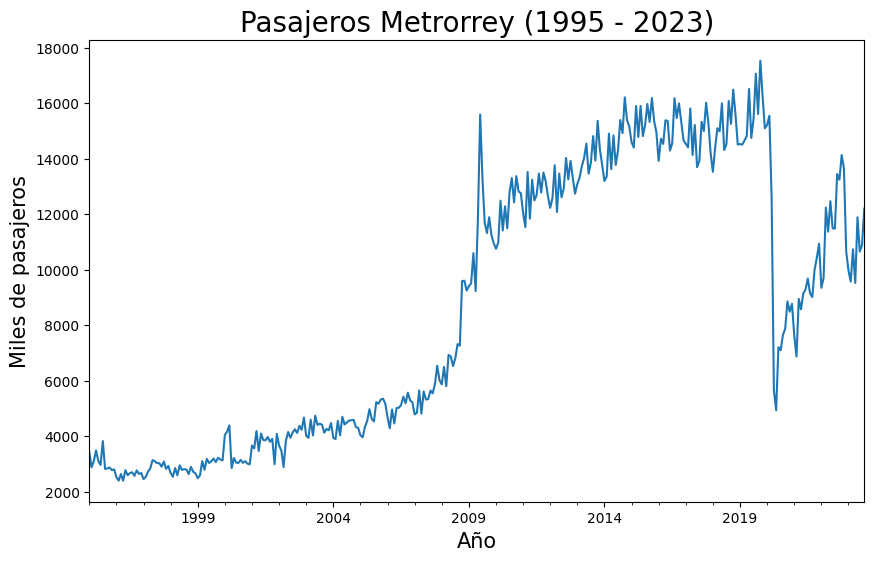

In [65]:
data['miles de pasajeros'].plot(figsize=(10,6))
plt.title('Pasajeros Metrorrey (1995 - 2023)', fontsize=20)
plt.xlabel('Año', fontsize=15)
plt.ylabel('Miles de pasajeros', fontsize=15)
plt.show()

b)Una media móvil centradaa 6 meses, y explica si la serie tiene tendencia o no, y si existen ciclos (subidas y caídas) y que se debe cada uno

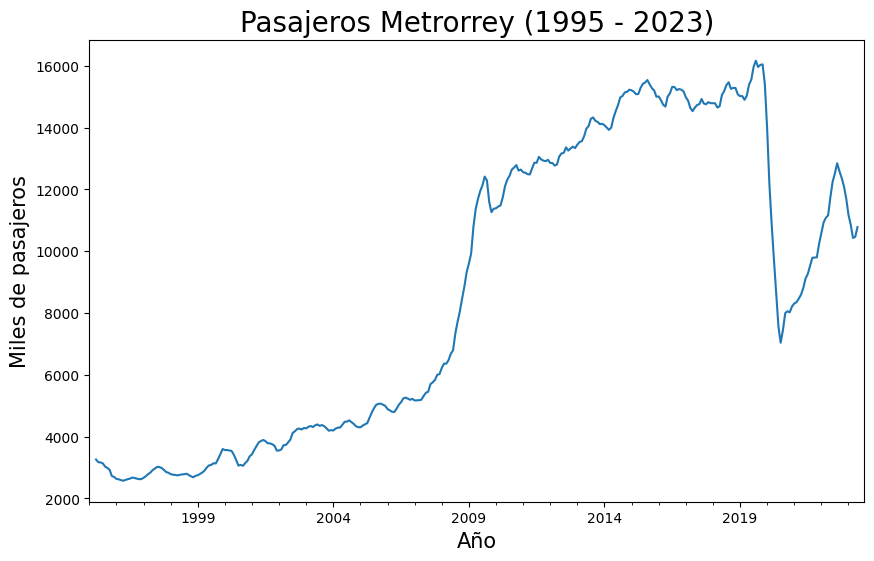

Se puede apreciar una tendencia creciente teniendo a lo largo del tiempo con una subida muy fuerte alrededor del 2009, esto podria
ser a causa de la apliacion que ubo en 2007 y 2008 en la lineas. Tambien podemos notar una decaida en 2020 esto a causa de la pandemia.


In [97]:
data['miles de pasajeros'].rolling(7, center=True).mean().plot(figsize=(10,6))
plt.title('Pasajeros Metrorrey (1995 - 2023)', fontsize=20)
plt.xlabel('Año', fontsize=15)
plt.ylabel('Miles de pasajeros', fontsize=15)
plt.show()

print('Se puede apreciar una tendencia creciente teniendo a lo largo del tiempo con una subida muy fuerte alrededor del 2009, esto podria\nser a causa de la apliacion que ubo en 2007 y 2008 en la lineas. Tambien podemos notar una decaida en 2020 esto a causa de la pandemia.')

4.Eldirector  de  Metrorrey  planea  hacer  mantenimiento  a  las  estaciones  y  los vagones,  pero  no  sabe  la  fecha  adecuada  para  hacerlo.  Utiliza  el  modelo  ETS para  obtener  el  componente  estacional  de  la  serie  y  señala  el  mes  o  meses adecuados para dar mantenimiento(8.2 puntos).

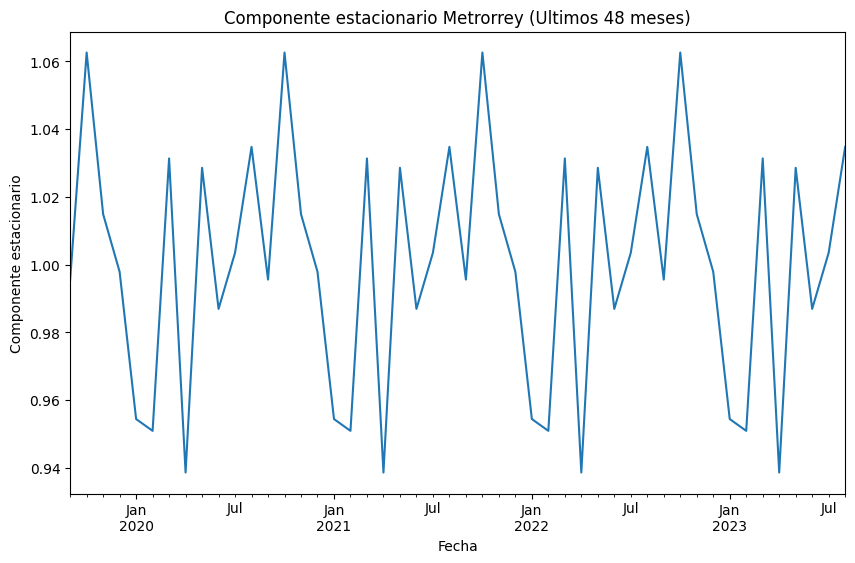

Mediante la grafica podemos notar que el mes en el que menor cantidad de pasajeros son registrados es en Abril.
Por otro lado, otro buen mes para dar mantenimiento es en Enero y Febrero que mantienen una baja en cuanto a pasajeros.
Lo recomendado segun el tiempo que lleva el dar mantenimento a las estaciones seria si dura aproximadamente 2 meses, empezar
en Enero y si no tarda mucho, entonces Abril es el mes indicado


In [120]:
componente_esyaconal = sm.tsa.seasonal_decompose(data['miles de pasajeros'], model="multiplicative").seasonal
componente_esyaconal[-48:].plot(figsize=(10,6))
plt.title('Componente estacionario Metrorrey (Ultimos 48 meses)') # Solo grafique los ultimos 48 mese para ver mas de cerca la grafica
plt.ylabel('Componente estacionario')
plt.xlabel('Fecha')
plt.show()

print('Mediante la grafica podemos notar que el mes en el que menor cantidad de pasajeros son registrados es en Abril.\nPor otro lado, otro buen mes para dar mantenimiento es en Enero y Febrero que mantienen una baja en cuanto a pasajeros.\nLo recomendado segun el tiempo que lleva el dar mantenimento a las estaciones seria si dura aproximadamente 2 meses, empezar\nen Enero y si no tarda mucho, entonces Abril es el mes indicado')

5.El  director  de  Metrorrey  quiere  saber  los  ingresos  por  pasaje  y  el  número  de pasajeros  los  siguientes  5  meses. Utiliza  el  método  de  Holt-Winters  para pronosticar  el  número  de  pasajeros los  próximos  5  meses,  cada  pronóstico multiplícalo por $7.1 para tener un estimado de los ingresos(8.2 puntos).  

In [151]:
pronostico_5m = (ExponentialSmoothing(data['miles de pasajeros'], trend='add', seasonal='mul', seasonal_periods=12).fit().forecast(5))*7.1
print(f'El pronostico para los siguientes 5 meses son:\n\n{pronostico_5m}')



El pronostico para los siguientes 5 meses son:

2023-09-01    81232.419972
2023-10-01    85188.386439
2023-11-01    79526.048227
2023-12-01    74078.637313
2024-01-01    70766.975244
Freq: MS, dtype: float64


c:\Users\A\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


6.Realiza   un   pronósticode   los   miles   de   pasajeroscon   el   modelo   ARIMA cumpliendo los siguientes pasos:

a)Realiza una prueba de raíz unitaria a la serie original(8.2 puntos)

In [161]:
prueba_adf = adfuller(data['miles de pasajeros'])
pvalor = prueba_adf[1]
print(f'Ho: La serie no es estacionaria\nHa: La serie es estacionaria\n\np_valor = {pvalor.round(2)} > 0.05\nNo rechazamos H0. La serie no es estacionaria.')

Ho: La serie no es estacionaria
Ha: La serie es estacionaria

p_valor = 0.58 > 0.05
No rechazamos H0. La serie no es estacionaria.


b)En caso de que no sea estacionaria aplica primeras diferencias, y realiza la prueba de raíz unitaria para verificar que la serie sea estacionaria(8.2 puntos)

In [168]:
data['pasajeros_diff'] = data['miles de pasajeros'].diff()
prueba_adf2 = adfuller(data['pasajeros_diff'].dropna())
pvalor = prueba_adf2[1]
print(f'Ho: La serie no es estacionaria\nHa: La serie es estacionaria\n\np_valor = {pvalor.round(2)} < 0.05\nRechazamos H0. La serie es estacionaria.')

Ho: La serie no es estacionaria
Ha: La serie es estacionaria

p_valor = 0.0 < 0.05
Rechazamos H0. La serie es estacionaria.


c)Si  la  serie  no  es  estacionaria  repite  el  paso  b  hasta  que  la  serie  sea estacionaria.

In [169]:
# Si es estacionaria aplicando primeras diferencias 1 vez.

d)Realiza  las  graficas  de  autocorrelación  de  la  serie  estacionaria  para verificar si la serie tiene o no un componente estacional(8.2 puntos)

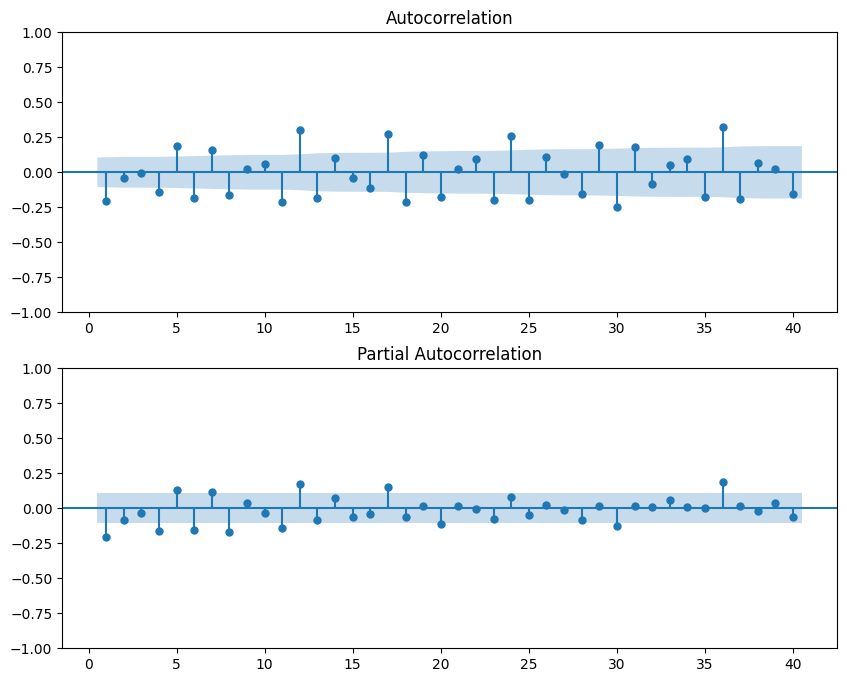

Las graficas de correlacion muestran un patrom regular, por lo tanto, significa que estamos ante unsa serie con componte estacionario.
Es decir, existen meses del año que los pasajeros siempre sube y otros meses que los pasajeros siempre baja.


In [173]:
# graficas de correlacion
ig, ax =plt.subplots(2,1,figsize = (10,8))
# 1er subgrafica
plot_acf(data['pasajeros_diff'].dropna(), zero = False, lags=40, ax=ax[0])
# 2da subgrafica
plot_pacf(data['pasajeros_diff'].dropna(), zero = False, lags=40, ax=ax[1])
plt.show()

print('Las graficas de correlacion muestran un patrom regular, por lo tanto, significa que estamos ante unsa serie con componte estacionario.\nEs decir, existen meses del año que los pasajeros siempre sube y otros meses que los pasajeros siempre baja.')

e)Utiliza auto_arimapara encontrar el orden del modelo arima, dando el parámetro information_criterionprueba y muestra el resultado, con aic, bic, hqic, oob, en caso de que resulten diferente elegir aic si tu matricula termina en par, sino termina en par elegir uno distinto a aic.(8.2 puntos)

In [175]:
print('AIC ',pm.auto_arima(data['miles de pasajeros'],start_p=1, start_q=1,max_p=10,max_q=10,
              seasonal=True,m=12,start_P=1, start_Q=1,max_P=10, max_Q=10,
              ic='aic',))
print('BIC ',pm.auto_arima(data['miles de pasajeros'],start_p=1, start_q=1,max_p=10,max_q=10,
              seasonal=True,m=12,start_P=1, start_Q=1,max_P=10, max_Q=10,
              ic='bic',))
print('HQIC',pm.auto_arima(data['miles de pasajeros'],start_p=1, start_q=1,max_p=10,max_q=10,
              seasonal=True,m=12,start_P=1, start_Q=1,max_P=10, max_Q=10,
              ic='hqic',))
print('OOB ',pm.auto_arima(data['miles de pasajeros'],start_p=1, start_q=1,max_p=10,max_q=10,
              seasonal=True,m=12,start_P=1, start_Q=1,max_P=10, max_Q=10,
              ic='oob',))

AIC   ARIMA(1,1,3)(1,0,1)[12]          
BIC   ARIMA(1,1,3)(1,0,1)[12]          
HQIC  ARIMA(1,1,3)(1,0,1)[12]          
OOB   ARIMA(1,1,3)(1,0,1)[12]          


f)Con  el  orden  del  modelo  arima  obtenido  estima  el  modelo  arima(8.2 puntos)

In [177]:
modelo = ARIMA(data['miles de pasajeros'], order=(1,1,3), seasonal_order=(1,0,1,12))
results = modelo.fit()
print(results.summary())

c:\Users\A\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                 miles de pasajeros   No. Observations:                  344
Model:             ARIMA(1, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -2772.716
Date:                            Sat, 04 Nov 2023   AIC                           5559.433
Time:                                    05:10:30   BIC                           5586.297
Sample:                                01-01-1995   HQIC                          5570.134
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9508      0.037    -25.528      0.000      -1.024      -0.878
ma.L1          0.9126      0.050   

c:\Users\A\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


g)Realiza la gráfica del pronóstico a 5 meses con los intervalos de confianza y la serie original desde 2021(8.2 puntos)

Text(0.5, 0, 'Fecha')

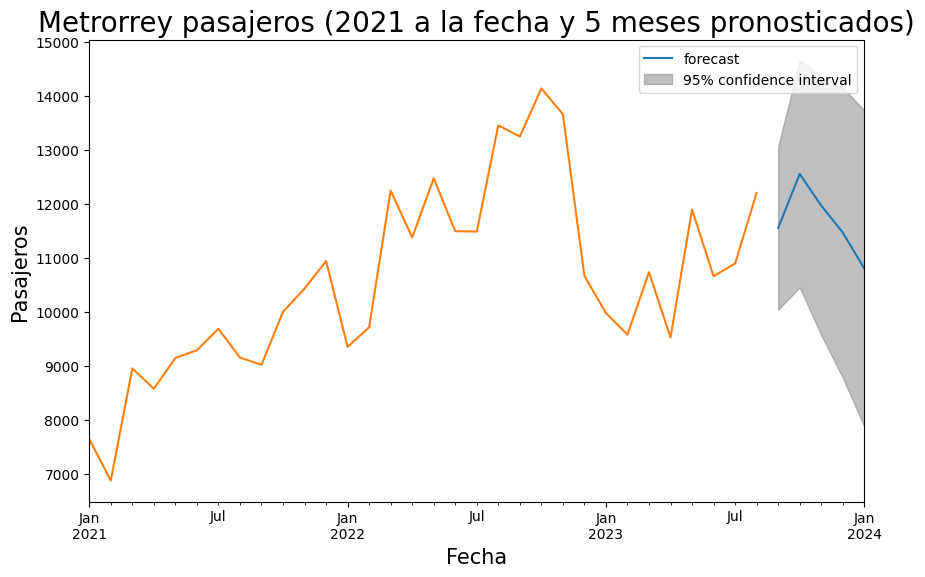

In [196]:
plot_predict(results, start='2023-09-01', end='2024-01-01')
data['miles de pasajeros']['2021':].plot(figsize=(10,6))
plt.title('Metrorrey pasajeros (2021 a la fecha y 5 meses pronosticados)', fontsize=20)
plt.ylabel('Pasajeros', fontsize=15)
plt.xlabel('Fecha', fontsize=15)

h)Realiza  el  pronostico  a  5  meses  con  los  intervalos  de  confianza(8.2 puntos)

In [201]:
pronostico = [results.predict('2023-08-01','2024-01-01')]
forecast = results.get_forecast(steps=5)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

inicio = '2023-08-01'
fin = '2024-01-01'
pronostico_valor = forecast_mean[inicio:fin]
pronostico_intervalos = forecast_ci.loc[inicio:fin]

# Juntarlos en un DF
df_forecast = pd.DataFrame({
    'pronostico_pasajeros':pronostico_valor,
    'limite inferior': pronostico_intervalos.iloc[:,0],
    'limite superior': pronostico_intervalos.iloc[:,1]
})

print(f'Pronostico de pasajeros de los siguientes 5 meses:\n\n{df_forecast.round(2)}')

Pronostico de los siguientes 5 meses:

            pronostico_pasajeros  limite inferior  limite superior
2023-09-01              11550.77         10036.86         13064.67
2023-10-01              12552.86         10452.33         14653.40
2023-11-01              11966.54          9565.88         14367.19
2023-12-01              11468.97          8781.12         14156.82
2024-01-01              10801.94          7872.64         13731.24


i)Calcula los ingresos y el intervalo de los ingreso multiplicando por $7.1(8.2 puntos)

In [210]:
df_forecast_ingresos = (df_forecast*7.1).rename(columns={"pronostico_pasajeros": "pronostico_ingresos"})
print(f'Pronostico de ingrtesos de los siguientes 5 meses:\n\n{df_forecast_ingresos.round(2)}')

Pronostico de ingrtesos de los siguientes 5 meses:

            pronostico_ingresos  limite inferior  limite superior
2023-09-01             82010.45         71261.72         92759.18
2023-10-01             89125.33         74211.52        104039.14
2023-11-01             84962.42         67917.78        102007.07
2023-12-01             81429.70         62345.95        100513.45
2024-01-01             76693.77         55895.76         97491.77
